<a href="https://colab.research.google.com/github/AlexandreAdam/Censai/blob/eager2.4/notebooks/train_rim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AlexandreAdam/Censai.git
%cd Censai
!git checkout eager2.4 
!python setup.py install
!pip install wandb

Cloning into 'Censai'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 600 (delta 90), reused 108 (delta 41), pack-reused 427
Receiving objects: 100% (600/600), 13.60 MiB | 33.39 MiB/s, done.
Resolving deltas: 100% (323/323), done.
/content/Censai
Branch 'eager2.4' set up to track remote branch 'eager2.4' from 'origin'.
Switched to a new branch 'eager2.4'
running install
running bdist_egg
running egg_info
creating censai.egg-info
writing censai.egg-info/PKG-INFO
writing dependency_links to censai.egg-info/dependency_links.txt
writing top-level names to censai.egg-info/top_level.txt
writing manifest file 'censai.egg-info/SOURCES.txt'
writing manifest file 'censai.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/censai
copying censai/__init__.py -> build/lib/censai


In [2]:
# wanb login
%pip install wandb -q
%pip install tensorflow_addons
import wandb


     |████████████████████████████████| 706kB 7.4MB/s 


In [7]:
import tensorflow as tf
from censai.physical_model import PhysicalModel
from censai.data_generator import NISGenerator
from censai.definitions import RIM_UNET_CELL
from censai.utilities import nullwriter
import os
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
%matplotlib inline
os.mkdir("logs") # run only once

In [11]:
def main(args):
    if wndb:
          config = wandb.config
          config.learning_rate = args.lr
          config.batch_size = args.batch_size
          config.epochs = args.epochs
          config.architecture="Double RIM Unet"
          config.update(args)
    gen = NISGenerator(args.total_items, args.batch_size, model="rim", pixels=args.pixels) #TODO add noise to observed lens
    gen_test = NISGenerator(args.validation, args.validation, train=False, model="rim", pixels=args.pixels)
    phys = PhysicalModel(pixels=args.pixels, noise_rms=args.noise_rms)
    rim = RIM_UNET_CELL(phys, args.batch_size, args.time_steps, args.pixels)
    optim = tf.optimizers.Adam(args.lr)
	# setup tensorboard writer (nullwriter in case we do not want to sync)
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, args.logname)
        traindir = os.path.join(logdir, "train")
        testdir = os.path.join(logdir, "test")
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        if not os.path.isdir(traindir):
            os.mkdir(traindir)
        if not os.path.isdir(testdir):
            os.mkdir(testdir)
        train_writer = tf.summary.create_file_writer(traindir)
        test_writer = tf.summary.create_file_writer(testdir)
    else:
        test_writer = nullwriter()
        train_writer = nullwriter()

    epoch_loss = tf.metrics.Mean()
    best_loss = np.inf
    patience = args.patience
    step = 1
    # if args.kappalog:
    #     link = lambda x: tf.math.log(x) / tf.math.log(10.)
    #     invlink = lambda x: 10.**(x)
    # else:
    #     link = lambda x: x
    #     invlink = lambda x: x
    step = 1
    for epoch in range(args.epochs):
        epoch_loss.reset_states()
        with train_writer.as_default():
            for batch, (kappa, source, Y) in enumerate(gen):
                with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:
                    tape.watch(rim.model_1.trainable_variables)
                    tape.watch(rim.model_2.trainable_variables)
                    cost = rim.cost_function(Y, source, kappa)
                gradient1 = tape.gradient(cost, rim.model_1.trainable_variables)
                gradient2 = tape.gradient(cost, rim.model_2.trainable_variables)
                # clipped_gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
                optim.apply_gradients(zip(gradient1, rim.model_1.trainable_variables)) # backprop
                optim.apply_gradients(zip(gradient2, rim.model_2.trainable_variables))

                #========== Summary and logs ==========
                epoch_loss.update_state([cost])
                tf.summary.scalar("MSE", cost, step=step)
                step += 1
            # tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
        with test_writer.as_default():
            for (kappa, source, Y) in gen_test:
                test_cost = rim.cost_function(Y, source, kappa)
            tf.summary.scalar("MSE", test_cost, step=step)
        print(f"epoch {epoch} | train loss {epoch_loss.result().numpy():.3e} | val loss {test_cost.numpy():.3e}") #| learning rate {optim.lr(step).numpy():.2e}")
        if test_cost < best_loss - args.tolerance:
            best_loss = test_cost
            patience = args.patience
        else:
            patience -= 1
        if patience == 0:
            print("Reached patience")
            break
    return gen, gen_test, rim, epoch_loss.result()

In [17]:
# quick hack to make a config like args of ArgumentParser
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

lr = 1e-3
decay_steps=100
decay_rate=0.95
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)
init_range = 0.1
# initializer = tf.keras.initializers.RandomUniform(minval=-init_range, maxval=init_range)
# initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=init_range)
initializer = tf.keras.initializers.GlorotNormal()
# setup hyperparameter and other configs
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
Config = AttrDict()
Config.update({
    #hparams
    "epochs": 10,
    "lr": lr, # initial learning rate
    "decay_steps": decay_steps,
    "decay_rate": decay_rate,
    "batch_size": 10,
    "kappalog": False,
    "clipping": False,
    "pixels": 64,
    "noise_rms": 0.1,
    "time_steps": 8,
    # "initializer_range":init_range,
    "initializer_type": "glorot_normal",
    "optimizer_name": "Adam",
    #configs
    "total_items": 100, # items per epochs
    "logdir": "logs",
    "logname": date,
    "validation": 10,
    "patience": np.inf,
    "tolerance": 0,
    # "schedule": lr_schedule,
    "initializer": initializer,
    "optimizer": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    "note": "Data generator updated parameter space. x_c does not vary anymore, fixed t0 0.05"

})


In [18]:
wndb = True
wandb.init(project="censai", entity="adam-alexandre01123", sync_tensorboard=True)
gen, gen_test, rim, loss = main(Config)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


epoch 0 | train loss 1.596e+00 | val loss 9.980e-01
epoch 1 | train loss 3.912e+00 | val loss 9.965e-01
epoch 2 | train loss 3.030e+00 | val loss 9.942e-01
epoch 3 | train loss 8.685e-01 | val loss 9.919e-01
epoch 4 | train loss 1.977e+00 | val loss 9.873e-01
epoch 5 | train loss 1.321e+00 | val loss 1.002e+00
epoch 6 | train loss 9.562e-01 | val loss 9.969e-01
epoch 7 | train loss 1.964e+00 | val loss 9.971e-01
epoch 8 | train loss 1.267e+00 | val loss 9.941e-01
epoch 9 | train loss 1.811e+00 | val loss 9.945e-01


In [46]:
X, source, kap = gen[8]

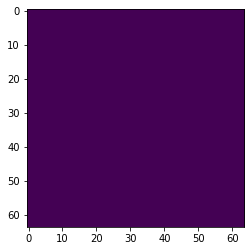

In [49]:
plt.imshow(X.numpy()[0, ..., 0])

(array([3.9384e+04, 2.5300e+02, 1.5300e+02, 1.0300e+02, 6.7000e+01,
        5.8000e+01, 6.5000e+01, 4.6000e+01, 3.7000e+01, 3.0000e+01,
        2.9000e+01, 3.4000e+01, 2.8000e+01, 1.8000e+01, 1.8000e+01,
        1.7000e+01, 1.6000e+01, 1.7000e+01, 1.9000e+01, 1.7000e+01,
        1.5000e+01, 1.3000e+01, 1.2000e+01, 1.0000e+01, 1.6000e+01,
        1.2000e+01, 8.0000e+00, 1.2000e+01, 1.5000e+01, 1.3000e+01,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 9.0000e+00, 7.0000e+00,
        1.6000e+01, 1.1000e+01, 1.0000e+01, 4.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 1.3000e+01, 1.0000e+01, 1.1000e+01,
        8.0000e+00, 7.0000e+00, 6.0000e+00, 8.0000e+00, 7.0000e+00,
        2.0000e+00, 5.0000e+00, 4.0000e+00, 9.0000e+00, 1.0000e+01,
        2.0000e+00, 1.3000e+01, 5.0000e+00, 1.0000e+01, 5.0000e+00,
        6.0000e+00, 5.0000e+00, 0.0000e+00, 5.0000e+00, 3.0000e+00,
        4.0000e+00, 7.0000e+00, 1.0000e+00, 8.0000e+00, 2.0000e+00,
        7.0000e+00, 7.0000e+00, 6.0000e+00, 8.00

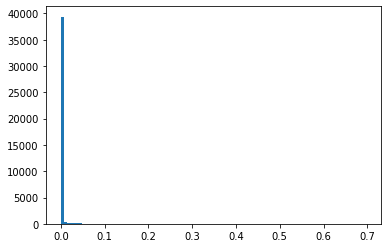

In [32]:
plt.hist(X.numpy().ravel(), bins=100)